In [56]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from notebooks import utils
%matplotlib inline

In [57]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:///home/cloudera/Downloads/big-data-4/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [58]:
df.count()

1587257

In [110]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [115]:
tempDF = filteredDF.na.drop()
tempDF.count()


158679

In [116]:
tempDF.stat.corr('min_wind_speed', 'avg_wind_speed')

0.9708620631891018

In [60]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102434,3.051716552830638,905.0,929.5
air_temp,158726,61.851589153636304,11.833569210641757,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057623969742642,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4188016208098886,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784567,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421125052424393,0.0,31.6


In [61]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count()

157812

In [62]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count()

157237

In [25]:
# The weather measurements in this dataset were collected during a drought in San Diego and because of that both rain_accumulation
# and rain_duration have 0 values in most samples. Hence, we can drop these two columns.
# We can also drop hpwren_timestamp column since we don't use it.
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')
workingDF.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102434,3.051716552830638,905.0,929.5
air_temp,158726,61.851589153636304,11.833569210641757,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057623969742642,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4188016208098886,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784567,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421125052424393,0.0,31.6


In [64]:
before = workingDF.count()
#Drop rows with missing values
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [65]:
#Normalize the data with 0 mean and 1 SD
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [66]:
#Combine columns into a single vector; 
featuresUsed = ['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']


In [67]:
assembler = VectorAssembler(inputCols = featuresUsed, outputCol = "features_unscaled")
assembled = assembler.transform(workingDF)
assembled.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158680,793627.3355810436,458198.0363632447,0,1587250
air_pressure,158680,916.8304071086608,3.0516872463866034,905.0,929.5
air_temp,158680,61.85578258129617,11.83251581712244,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057623969742642,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4188016208098886,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784567,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421125052424393,0.0,31.6


In [69]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol = "features", withStd = True, withMean = True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [70]:
scaledData.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158680,793627.3355810436,458198.0363632447,0,1587250
air_pressure,158680,916.8304071086608,3.0516872463866034,905.0,929.5
air_temp,158680,61.85578258129617,11.83251581712244,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,2.775214897907747,2.057623969742642,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,3.400557726241518,2.4188016208098886,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784567,0.0,359.0
min_wind_speed,158680,2.1346641038568754,1.7421125052424393,0.0,31.6


In [71]:
scaledData = scaledData.select("features", "rowID")

In [72]:
scaledData.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158680,793627.3355810436,458198.0363632447,0,1587250


In [73]:
#Elbown method is very compute-intensive; hence reduce the data size
elbowset =scaledData.filter((scaledData.rowID % 3) == 0).select("features")

In [74]:
#Request Spark to keep the data in memory if possible
elbowset.persist()

DataFrame[features: vector]

In [75]:
clusters = range(2, 31)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 114993.13181214454 
Training for cluster size 3 
......................WSSE = 104181.0978581738 
Training for cluster size 4 
......................WSSE = 94577.27151288436 
Training for cluster size 5 
......................WSSE = 87993.46098415818 
Training for cluster size 6 
......................WSSE = 85084.23922296542 
Training for cluster size 7 
......................WSSE = 81664.96024487517 
Training for cluster size 8 
......................WSSE = 78397.76745113655 
Training for cluster size 9 
......................WSSE = 76599.60815784344 
Training for cluster size 10 
......................WSSE = 74023.93930498546 
Training for cluster size 11 
......................WSSE = 72772.61056038193 
Training for cluster size 12 
......................WSSE = 70281.81723912072 
Training for cluster size 13 
......................WSSE = 69473.53243631397 
Training for cluster size 14 
......................WSSE = 68756.123291

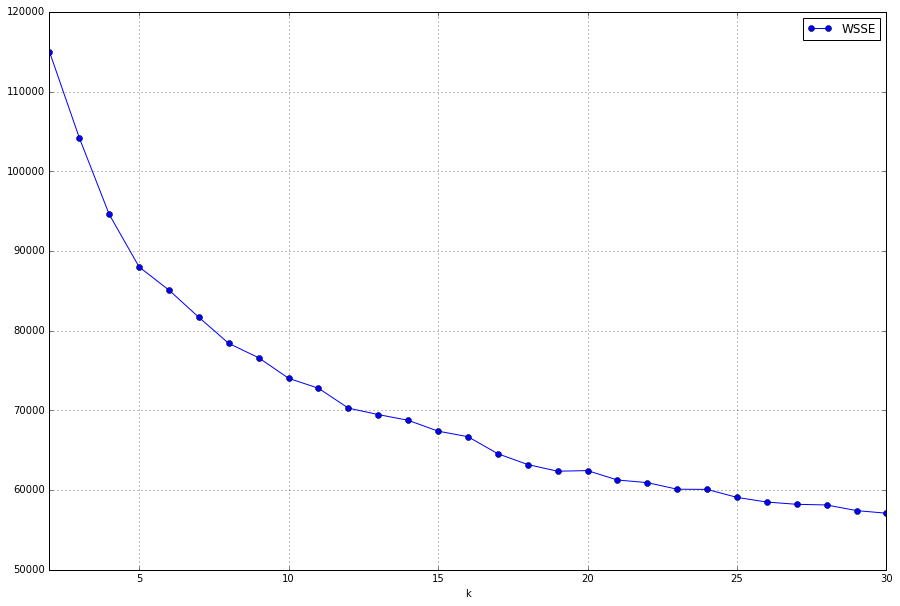

In [76]:
utils.elbow_plot(wsseList, clusters)

In [77]:
#Let's select k = 12
scaledDataFeat = scaledData.select("features")

In [78]:
scaledDataFeat.persist()

DataFrame[features: vector]

In [117]:
kmeans = KMeans(k=12, seed=1)
#kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(scaledDataFeat)

In [118]:
transformed = model.transform(scaledDataFeat)

In [119]:
centers = model.clusterCenters()

In [120]:
centers

[array([-0.13720796,  0.6061152 ,  0.22970948, -0.62174454,  0.40604553,
        -0.63465994, -0.42215364]),
 array([ 1.42238994, -0.10953198, -1.10891543, -0.07335197, -0.96904335,
        -0.05226062, -0.99615617]),
 array([-0.63637648,  0.01435705, -1.1038928 , -0.58676582, -0.96998758,
        -0.61362174,  0.33603011]),
 array([-0.22385278, -1.06643622,  0.5104215 , -0.24620591,  0.68999967,
        -0.24399706,  1.26206479]),
 array([ 1.17896517, -0.25134204, -1.15089838,  2.11902126, -1.04950228,
         2.23439263, -1.12861666]),
 array([-1.14087425, -0.979473  ,  0.42483303,  1.68904662,  0.52550171,
         1.65795704,  1.03863542]),
 array([ 0.50746307, -1.08840683, -1.20882766, -0.57604727, -1.0367013 ,
        -0.58206904,  0.97099067]),
 array([ 0.14064028,  0.83834618,  1.89291279, -0.62970435, -1.54598923,
        -0.55625032, -0.75082891]),
 array([-0.0339489 ,  0.98719067, -1.33032244, -0.57824562, -1.18095582,
        -0.58893358, -0.81187427]),
 array([-0.22747944

In [121]:
p = utils.pd_centers(featuresUsed, centers)

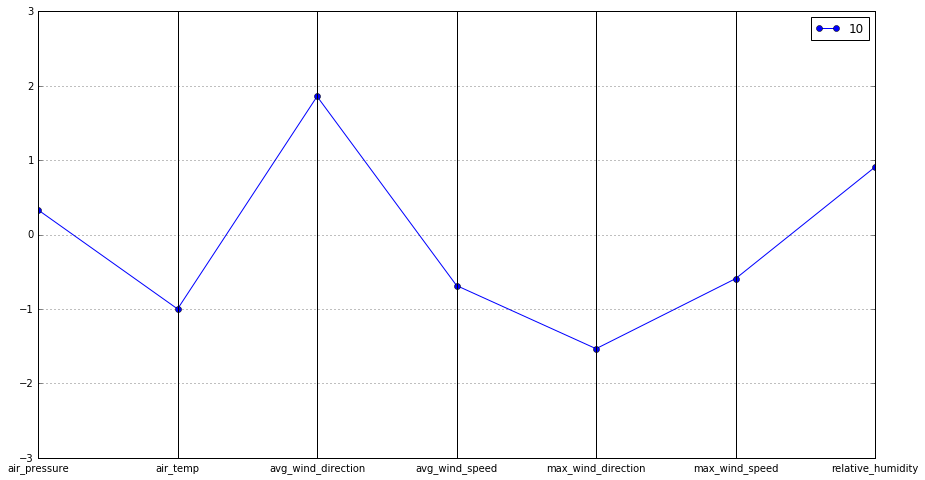

In [123]:
utils.parallel_plot(p.iloc[[10]], p)

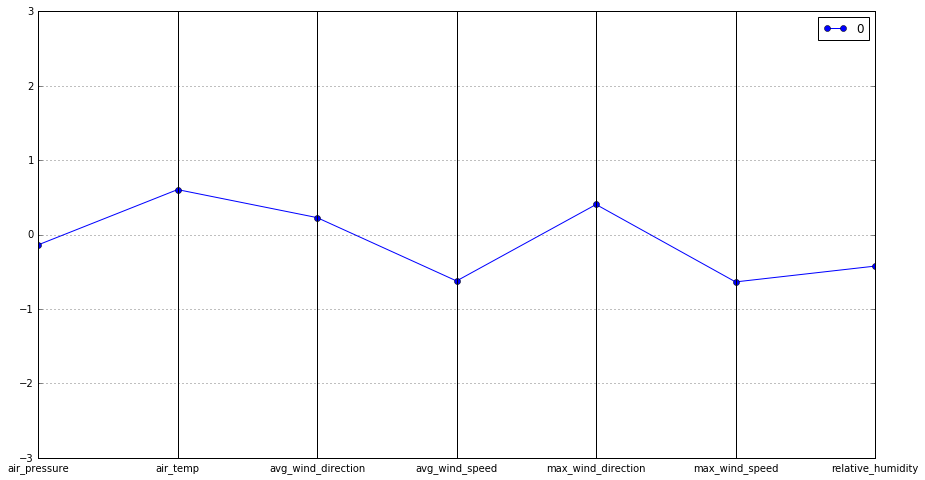

In [131]:
utils.parallel_plot(p.iloc[[0]], p)

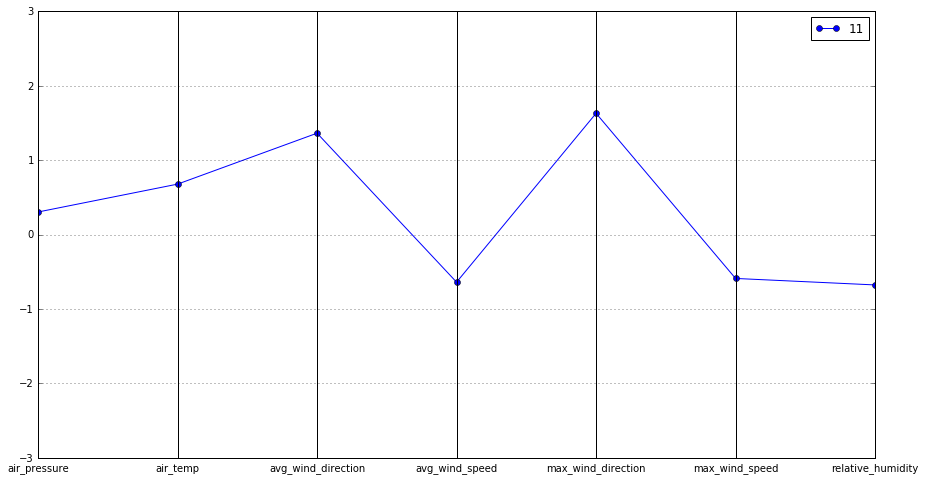

In [126]:
utils.parallel_plot(p.iloc[[11]], p)

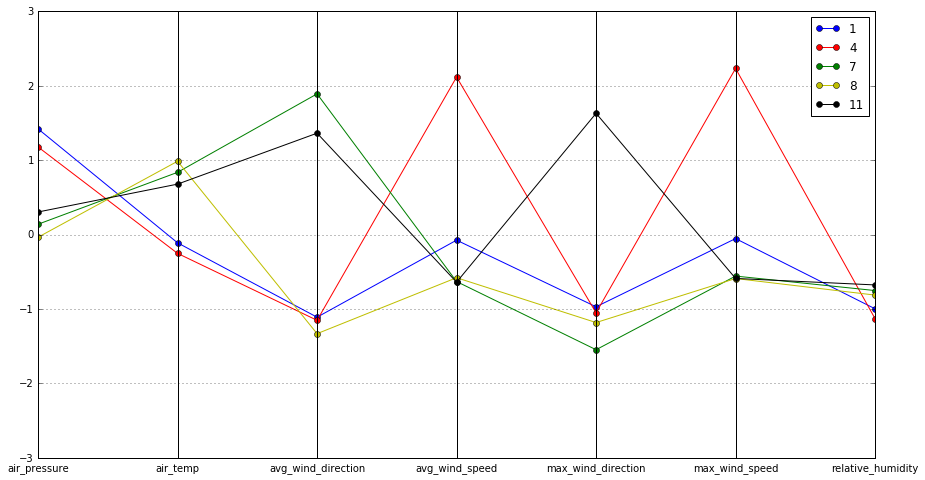

In [127]:
utils.parallel_plot(p[p['relative_humidity'] < - 0.5], p)

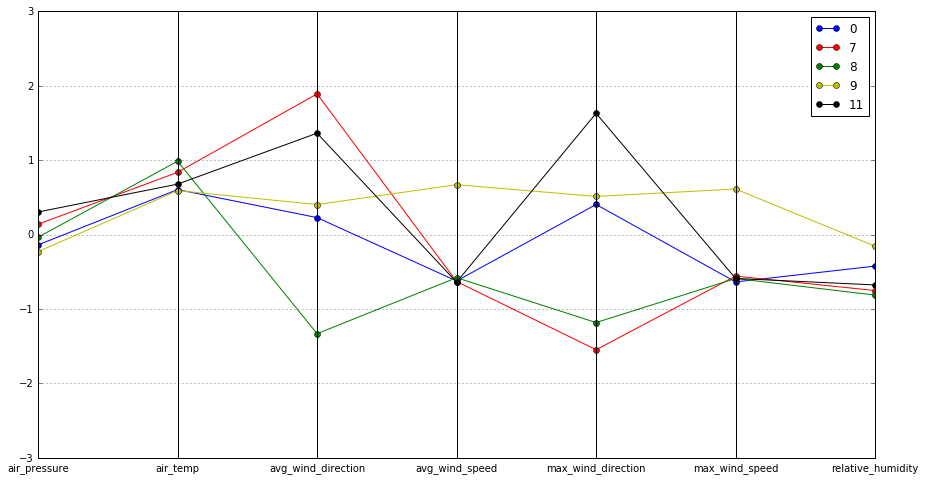

In [128]:
utils.parallel_plot(p[p['air_temp'] > 0.5], p)

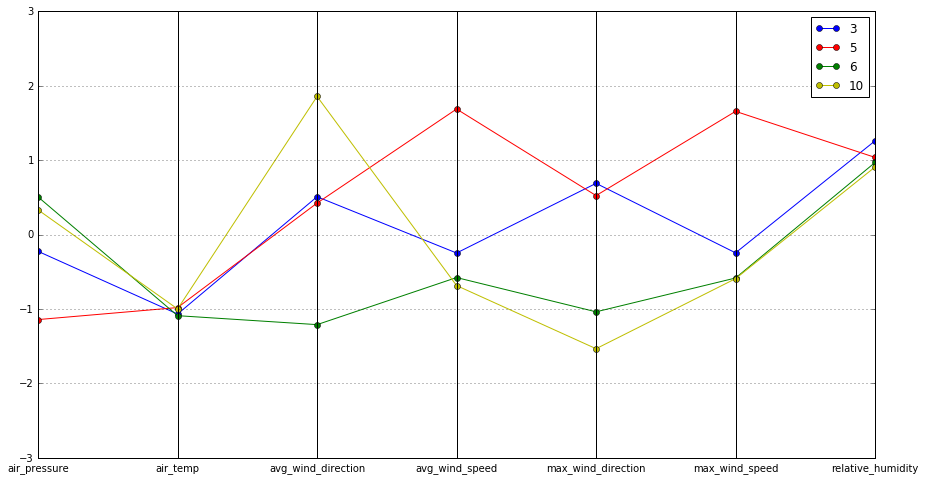

In [129]:
utils.parallel_plot(p[(p['relative_humidity'] > 0.5) & (p['air_temp'] < 0.5)], p)

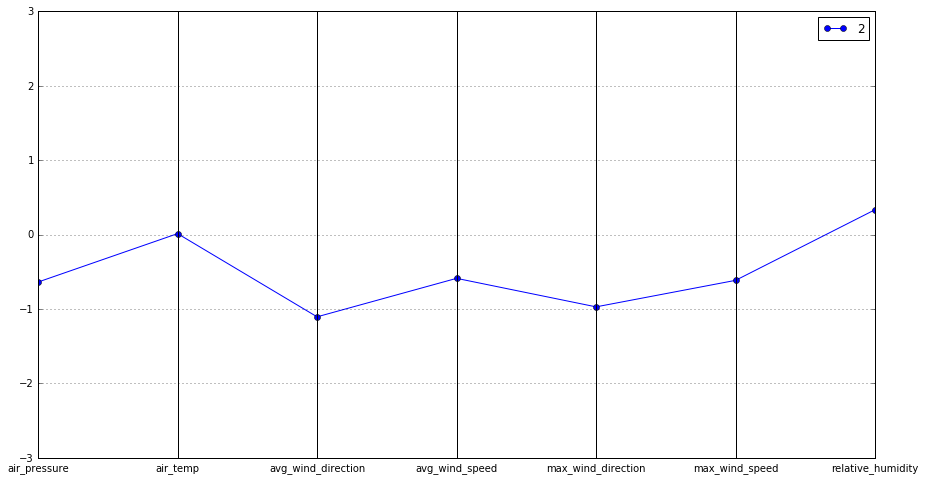

In [130]:
utils.parallel_plot(p.iloc[[2]], p)